# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [6]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [7]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [8]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier
from ls_ood_detect.metrics import get_ood_detector_results, plot_roc_ood_detector

# Distribution Shift Detection Steps

Steps for using the package:

1. Load you Dataloader Pytorch-Lightning Module
2. Load your trained DNN PyTorch-Lightning Module
3. Add Hook to DNN Module for MC samples extraction
4. Get Monte-Carlo (MC) samples for In-Distribution (InD) samples dataloader, and Out-of-Distribution (OoD) samples dataloader
5. Get Entropy from InD and OoD MC samples
6. Build OoD Detection dataset (with InD and OoD samples)
7. Build OoD data-driven Detector (classifier)
8. Show OoD performance results

# Datasets

## Cityscapes

### Datamodules

In [9]:
dataset_path = './Data/DATASETS/CityScapes'
batch_size = 1

__Cityscapes img_size (256, 512)__

In [10]:
cs_dm_normal_dlv3p = CityscapesDataModule(data_dir=dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be True!
                                          default_img_mask_transforms=True) # And here this should be False!

In [11]:
cs_dm_normal_2_dlv3p = CityscapesDataModule(data_dir=dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be True!
                                          default_img_mask_transforms=True) # And here this should be False!

In [12]:
cs_dm_normal_2_dlv3p.train_img_mask_transforms = cs_dm_normal_2_dlv3p.val_img_mask_transforms

In [13]:
cs_dm_normal_2_dlv3p.train_img_mask_transforms

Compose([
  Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.28689554, 0.32513303, 0.28389177], std=[0.18696375, 0.19017339, 0.18720214], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [14]:
cs_dm_normal_2_dlv3p.val_img_mask_transforms

Compose([
  Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.28689554, 0.32513303, 0.28389177], std=[0.18696375, 0.19017339, 0.18720214], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

__Cityscapes img_size (483, 640)__

In [15]:

cs_483640_dm_dlv3p = CityscapesDataModule(data_dir=dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(483, 640),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=True, # Here this should be True!
                                          default_img_mask_transforms=False) # And here this should be False!        

__Cityscapes-Anomalies img_size (256, 512)__

In [16]:
cs_dm_anomal_dlv3p = CityscapesDataModule(data_dir=dataset_path,
                                          batch_size=batch_size,
                                          target_type='semantic',
                                          img_size=(256, 512),
                                          num_workers=10,
                                          drop_last=True,
                                          default_transforms=False, # Here this should be False!
                                          default_img_mask_transforms=True) # And here this should be True! (Enable Anomalies)

### Cityscapes Dataloaders

In [17]:
cs_dlv3p_train_loader = cs_dm_normal_dlv3p.train_dataloader()
cs_dlv3p_valid_loader = cs_dm_normal_dlv3p.val_dataloader()
cs_dlv3p_test_loader = cs_dm_normal_dlv3p.test_dataloader()

In [18]:
cs_dlv3p_anomaly_valid_loader = cs_dm_anomal_dlv3p.anomaly_val_dataloader()
cs_dlv3p_anomaly_test_loader = cs_dm_anomal_dlv3p.anomaly_test_dataloader()

In [19]:
cs_483640_dlv3p_valid_loader = cs_483640_dm_dlv3p.val_dataloader()
cs_483640_dlv3p_test_loader = cs_483640_dm_dlv3p.test_dataloader()

In [20]:
ic(len(cs_dlv3p_train_loader));
ic(len(cs_dlv3p_valid_loader));
ic(len(cs_dlv3p_test_loader));
ic(len(cs_dlv3p_anomaly_valid_loader));
ic(len(cs_dlv3p_anomaly_test_loader));

ic| len(cs_dlv3p_train_loader): 2975
ic| len(cs_dlv3p_valid_loader): 500
ic| len(cs_dlv3p_test_loader): 1525
ic| len(cs_dlv3p_anomaly_valid_loader): 500
ic| len(cs_dlv3p_anomaly_test_loader): 1525


In [21]:
cs_dlv3p_train_loader_2 = cs_dm_normal_2_dlv3p.train_dataloader()

## Woodscape

### Datamodules

In [22]:
ws_dataset_path = './Data/DATASETS/WoodScape/'
batch_size = 1

cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }

# same values as in VainF Repository! - Probably not the best Values for Woodscapes!
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

__Woodscape img_size (483, 640)__

In [26]:
ws_dm_normal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


__Woodscape img_size (256, 512)__

In [27]:
ws_dm_normal_dlv3p_256_512 = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(256, 512),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p_256_512.setup()

DATASET Shuffle Random SEED:  9290


__Woodscape-Anomalies img_size (483, 640)__

In [28]:
ws_dm_anomal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_anomal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


### Woodscape dataloaders

In [29]:
ws_dlv3p_train_loader = ws_dm_normal_dlv3p.train_dataloader()
ws_dlv3p_valid_loader = ws_dm_normal_dlv3p.val_dataloader()
ws_dlv3p_test_loader = ws_dm_normal_dlv3p.test_dataloader()

In [30]:
ws_dlv3p_anomaly_valid_loader = ws_dm_anomal_dlv3p.anomaly_val_dataloader()
ws_dlv3p_anomaly_test_loader = ws_dm_anomal_dlv3p.anomaly_test_dataloader()

In [31]:
ws_256512_dlv3p_valid_loader = ws_dm_normal_dlv3p_256_512.val_dataloader()
ws_256512_dlv3p_test_loader = ws_dm_normal_dlv3p_256_512.test_dataloader()

In [32]:
ic(len(ws_256512_dlv3p_valid_loader));
ic(len(ws_256512_dlv3p_test_loader));

ic| len(ws_256512_dlv3p_valid_loader): 1482


ic| len(ws_256512_dlv3p_test_loader): 823


## Woodscape-Soiling

### Datamodules

__Woodscape Soling OoD DeeplabV3+ (483, 640)__

In [92]:
woodscape_soil_483640_dm = WoodScapeSoilingDataModule(dataset_dir=",/Data/DATASETS/WoodScape/soiling_dataset/",
                                                      img_size=(483, 640),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_483640_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


__Woodscape Soling OoD DeeplabV3+ (256, 512)__

In [93]:
woodscape_soil_256512_dm = WoodScapeSoilingDataModule(dataset_dir="./Data/DATASETS/WoodScape/soiling_dataset/",
                                                      img_size=(256, 512),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_256512_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| 

DATASET Shuffle Random SEED:  9290


len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000


ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


### Dataloaders

In [94]:
ws_soiling_483640_valid_loader = woodscape_soil_483640_dm.val_dataloader()
ws_soiling_483640_test_loader = woodscape_soil_483640_dm.test_dataloader()

In [95]:
ws_soiling_256512_valid_loader = woodscape_soil_256512_dm.val_dataloader()
ws_soiling_256512_test_loader = woodscape_soil_256512_dm.test_dataloader()

In [ ]:
ic(len(ws_soiling_256512_valid_loader));
ic(len(ws_soiling_256512_test_loader));

ic| len(ws_soiling_256512_valid_loader): 800
ic| len(ws_soiling_256512_test_loader): 1000


## Dataset Samples

### Cityscapes

In [33]:
dataiter_cs_train = iter(cs_dlv3p_train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


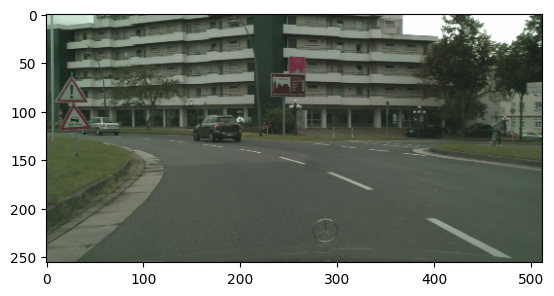

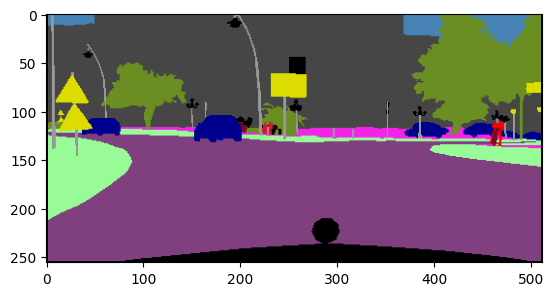

In [34]:
batch_ws_data, batch_ws_labels = dataiter_cs_train.next()
plt.figure()
show_dataset_image(batch_ws_data[0], cs_dm_anomal_dlv3p.norm_mean, cs_dm_anomal_dlv3p.norm_std)
plt.figure()
show_dataset_mask(batch_ws_labels[0].squeeze(), cs_dlv3p_train_loader.dataset.decode_target)
plt.show()

### Cityscapes-Anomalies

In [35]:
dataiter_cs_anomaly_valid = iter(cs_dlv3p_anomaly_valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


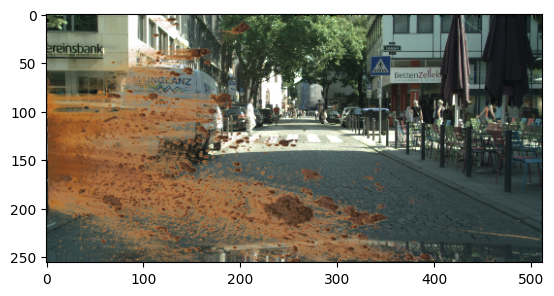

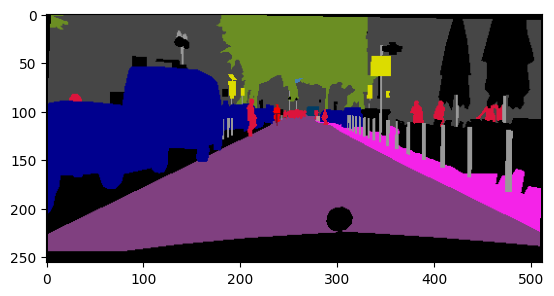

In [87]:
batch_ws_data, batch_ws_labels = dataiter_cs_anomaly_valid.next()
plt.figure()
show_dataset_image(batch_ws_data[0], cs_dm_anomal_dlv3p.norm_mean, cs_dm_anomal_dlv3p.norm_std)
plt.figure()
show_dataset_mask(batch_ws_labels[0].squeeze(), cs_dlv3p_train_loader.dataset.decode_target)
plt.show()

### Woodscape

In [48]:
dataiter_ws_soiling_valid = iter(ws_256512_dlv3p_valid_loader)

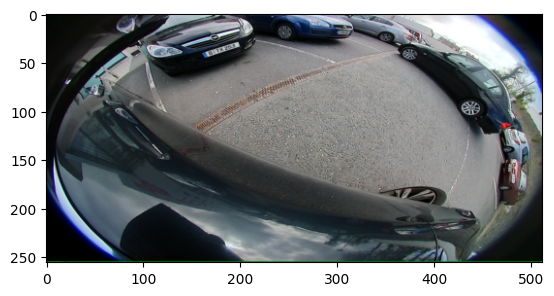

In [57]:
batch_ws_soil_data, batch_ws_soil_labels = dataiter_ws_soiling_valid.next()
plt.figure()
show_dataset_image(batch_ws_soil_data[0], ws_dm_normal_dlv3p_256_512.norm_mean, ws_dm_normal_dlv3p_256_512.norm_std)
plt.show()

### Woodscape-Soiling

In [96]:
dataiter_ws_soiling_valid = iter(ws_soiling_256512_valid_loader)

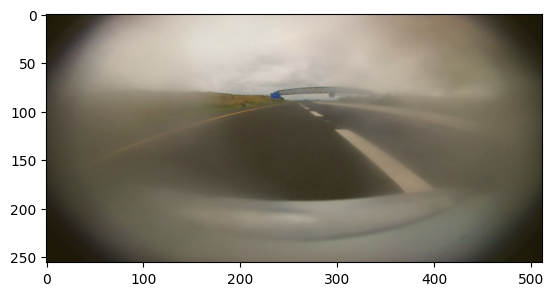

In [155]:
batch_ws_soil_data, batch_ws_soil_labels = dataiter_ws_soiling_valid.next()
plt.figure()
show_dataset_image(batch_ws_soil_data[0], ws_dm_normal_dlv3p_256_512.norm_mean, ws_dm_normal_dlv3p_256_512.norm_std)
plt.show()

# Deeplabv3+ Cityscapes Trained Model

In [9]:
cs_dlv3p_path = "./lightning_logs/version_158692/checkpoints/epoch=403-step=18584.ckpt"
cs_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=cs_dlv3p_path)


In [10]:
ic(cs_dlv3p_model.pred_loss_type);
ic(cs_dlv3p_model.n_class);

ic| cs_dlv3p_model.pred_loss_type: 'focal_loss'
ic| cs_dlv3p_model.n_class: 20


In [11]:
cs_dlv3p_model.eval();

In [14]:
cs_dlv3p_model.backbone_name

'resnet101'

In [15]:
cs_dlv3p_model

DeepLabV3PlusModule(
  (deeplab_v3plus_model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

# Add Hook Deeplabv3+ Woodscape

In [12]:
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()


ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.block_size: 8
ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.5
ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training: False


In [111]:
cs_dlv3p_hook_dropblock2d_layer = Hook(cs_dlv3p_model.deeplab_v3plus_model.drop_block1)

# Get Monte Carlo Samples

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [113]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def deeplabv3p_apply_dropout(m):
    if type(m) == torch.nn.Dropout or type(m) == DropBlock2D:
        m.train()

In [114]:
mc_samples = 16

In [115]:
cs_dlv3p_model.deeplab_v3plus_model.to(device);
cs_dlv3p_model.deeplab_v3plus_model.eval(); 
cs_dlv3p_model.deeplab_v3plus_model.apply(deeplabv3p_apply_dropout); # enable dropout

In [146]:
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.5
ic| cs_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


In [117]:
cs_dlv3p_cs_normal_train_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                      cs_dlv3p_train_loader,
                                                                      mc_samples,
                                                                      cs_dlv3p_hook_dropblock2d_layer)

In [147]:
cs_dlv3p_cs_normal_train_2_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                        cs_dlv3p_train_loader_2,
                                                                        mc_samples,
                                                                        cs_dlv3p_hook_dropblock2d_layer)

In [118]:
cs_dlv3p_cs_normal_valid_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                      cs_dlv3p_valid_loader,
                                                                      mc_samples,
                                                                      cs_dlv3p_hook_dropblock2d_layer)

cs_dlv3p_cs_normal_test_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                     cs_dlv3p_test_loader,
                                                                     mc_samples,
                                                                     cs_dlv3p_hook_dropblock2d_layer)

In [119]:
cs_dlv3p_cs_anomal_valid_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                      cs_dlv3p_anomaly_valid_loader,
                                                                      mc_samples,
                                                                      cs_dlv3p_hook_dropblock2d_layer)

cs_dlv3p_cs_anomal_test_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                     cs_dlv3p_anomaly_test_loader,
                                                                     mc_samples,
                                                                     cs_dlv3p_hook_dropblock2d_layer)

In [120]:
cs_dlv3p_ws_256512_valid_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                      ws_256512_dlv3p_valid_loader,
                                                                      mc_samples,
                                                                      cs_dlv3p_hook_dropblock2d_layer)

cs_dlv3p_ws_256512_test_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                     ws_256512_dlv3p_test_loader,
                                                                     mc_samples,
                                                                     cs_dlv3p_hook_dropblock2d_layer)

In [121]:
cs_dlv3p_ws_soiling_2565152_valid_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                              ws_soiling_256512_valid_loader,
                                                                              mc_samples,
                                                                              cs_dlv3p_hook_dropblock2d_layer)

cs_dlv3p_ws_soiling_2565152_test_16mc_samples = deeplabv3p_get_ls_mcd_samples(cs_dlv3p_model,
                                                                             ws_soiling_256512_test_loader,
                                                                             mc_samples,
                                                                             cs_dlv3p_hook_dropblock2d_layer)

In [122]:
torch.save(cs_dlv3p_cs_normal_train_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_normal_train_16mc_samples.pt')


In [148]:
torch.save(cs_dlv3p_cs_normal_train_2_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_normal_train_2_16mc_samples.pt')


In [123]:
torch.save(cs_dlv3p_cs_normal_valid_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_normal_valid_16mc_samples.pt')
torch.save(cs_dlv3p_cs_normal_test_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_normal_test_16mc_samples.pt')

In [124]:
torch.save(cs_dlv3p_cs_anomal_valid_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_anomal_valid_16mc_samples.pt')
torch.save(cs_dlv3p_cs_anomal_test_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_anomal_test_16mc_samples.pt')

In [125]:
torch.save(cs_dlv3p_ws_256512_valid_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_256512_valid_16mc_samples.pt')
torch.save(cs_dlv3p_ws_256512_test_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_256512_test_16mc_samples.pt')

In [135]:
cs_dlv3p_ws_soiling_256512_valid_16mc_samples = cs_dlv3p_ws_soiling_2565152_valid_16mc_samples
cs_dlv3p_ws_soiling_256512_test_16mc_samples = cs_dlv3p_ws_soiling_2565152_test_16mc_samples

In [126]:
torch.save(cs_dlv3p_ws_soiling_256512_valid_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_soiling_2565152_valid_16mc_samples.pt')
torch.save(cs_dlv3p_ws_soiling_256512_test_16mc_samples,
           './Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_soiling_2565152_test_16mc_samples.pt')

In [53]:
cs_dlv3p_cs_normal_train_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_cs_normal_train_16mc_samples.pt')
cs_dlv3p_cs_normal_valid_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/ws_dlv3p_ws_normal_valid_16mc_samples.pt')
cs_dlv3p_cs_normal_test_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/ws_dlv3p_ws_normal_test_16mc_samples.pt')

ws_dlv3p_ws_anomal_valid_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/ws_dlv3p_ws_anomal_valid_16mc_samples.pt')
ws_dlv3p_ws_anomal_test_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/ws_dlv3p_ws_anomal_test_16mc_samples.pt')

cs_dlv3p_ws_256512_valid_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_256512_valid_16mc_samples.pt')
cs_dlv3p_ws_256512_test_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_256512_test_16mc_samples.pt')

cs_dlv3p_ws_soiling_256512_valid_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_soiling_256512_valid_16mc_samples.pt')
cs_dlv3p_ws_soiling_256512_test_16mc_samples = torch.load('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/mc_samples/cs_dlv3p_ws_soiling_256512_test_16mc_samples.pt')

# Get Entropy

In [127]:
_, cs_dlv3p_h_z_cs_normal_train_samples_np = get_dl_h_z(cs_dlv3p_cs_normal_train_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (2975, 1)
ic| dl_h_z_samples_np.shape: (2975, 2048)


In [149]:
_, cs_dlv3p_h_z_cs_normal_train_2_samples_np = get_dl_h_z(cs_dlv3p_cs_normal_train_2_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (2975, 1)
ic| dl_h_z_samples_np.shape: (2975, 2048)


In [128]:
_, cs_dlv3p_h_z_cs_normal_valid_samples_np = get_dl_h_z(cs_dlv3p_cs_normal_valid_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (500, 1)
ic| dl_h_z_samples_np.shape: (500, 2048)


In [129]:
_, cs_dlv3p_h_z_cs_normal_test_samples_np = get_dl_h_z(cs_dlv3p_cs_normal_test_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (1525, 1)
ic| dl_h_z_samples_np.shape: (1525, 2048)


In [130]:
_, cs_dlv3p_h_z_cs_anomal_valid_samples_np = get_dl_h_z(cs_dlv3p_cs_anomal_valid_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (500, 1)
ic| dl_h_z_samples_np.shape: (500, 2048)


In [131]:
_, cs_dlv3p_h_z_cs_anomal_test_samples_np = get_dl_h_z(cs_dlv3p_cs_anomal_test_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (1525, 1)
ic| dl_h_z_samples_np.shape: (1525, 2048)


In [132]:
_, cs_dlv3p_h_z_ws_256512_valid_samples_np = get_dl_h_z(cs_dlv3p_ws_256512_valid_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (1482, 1)
ic| dl_h_z_samples_np.shape: (1482, 2048)


In [133]:
_, cs_dlv3p_h_z_ws_256512_test_samples_np = get_dl_h_z(cs_dlv3p_ws_256512_test_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (823, 1)
ic| dl_h_z_samples_np.shape: (823, 2048)


In [136]:
_, cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = get_dl_h_z(cs_dlv3p_ws_soiling_256512_valid_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (800, 1)
ic| dl_h_z_samples_np.shape: (800, 2048)


In [137]:
_, cs_dlv3p_h_z_ws_soil_256512_test_samples_np = get_dl_h_z(cs_dlv3p_ws_soiling_256512_test_16mc_samples, mcd_samples_nro=16)

ic| dl_h_mvn_z_samples_np.shape: (1000, 1)
ic| dl_h_z_samples_np.shape: (1000, 2048)


In [138]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_normal_train_samples_np',
        cs_dlv3p_h_z_cs_normal_train_samples_np)

In [150]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_normal_train_2_samples_np',
        cs_dlv3p_h_z_cs_normal_train_2_samples_np)

In [139]:
np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_normal_valid_samples_np',
        cs_dlv3p_h_z_cs_normal_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_normal_test_samples_np',
        cs_dlv3p_h_z_cs_normal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_anomal_valid_samples_np',
        cs_dlv3p_h_z_cs_anomal_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_cs_anomal_test_samples_np',
        cs_dlv3p_h_z_cs_anomal_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_ws_256512_valid_samples_np',
        cs_dlv3p_h_z_ws_256512_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_ws_256512_test_samples_np',
        cs_dlv3p_h_z_ws_256512_test_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_ws_soil_256512_valid_samples_np',
        cs_dlv3p_h_z_ws_soil_256512_valid_samples_np)

np.save('./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/cs_dlv3p_h_z_ws_soil_256512_test_samples_np',
        cs_dlv3p_h_z_ws_soil_256512_test_samples_np)

In [60]:
cs_dlv3p_cs_normal_train_16mc_samples[10:18]

tensor([[0.1595, 0.2185, 0.3795,  ..., 0.1542, 0.1325, 0.1618],
        [0.1811, 0.2257, 0.3074,  ..., 0.1370, 0.1273, 0.1507],
        [0.1595, 0.2185, 0.3795,  ..., 0.1542, 0.1325, 0.1618],
        ...,
        [0.1629, 0.2175, 0.3583,  ..., 0.1426, 0.1484, 0.2221],
        [0.2170, 0.1771, 0.3620,  ..., 0.1294, 0.1319, 0.1757],
        [0.2500, 0.1521, 0.3740,  ..., 0.1202, 0.1344, 0.1843]],
       device='cuda:0')

In [57]:
cs_dlv3p_h_z_cs_normal_train_samples_np

array([[-6.60150076, -7.14909191, -5.92773886, ..., -6.54541225,
        -6.85275173, -6.5274266 ],
       [-5.89570346, -6.08958639, -6.02772737, ..., -6.70281865,
        -6.25447377, -6.04617947],
       [-6.25389028, -6.45594035, -5.76108383, ..., -5.88771146,
        -6.32926514, -5.72976504],
       ...,
       [-8.50966903, -8.50245865, -8.06444075, ..., -8.41187157,
        -8.24187909, -8.28569328],
       [-7.44203968, -7.3850785 , -7.42218152, ..., -7.3725385 ,
        -7.0888539 , -7.41883274],
       [-5.60953949, -5.12651396, -5.14450085, ..., -5.6045959 ,
        -5.56944715, -5.63806066]])